# Two Site Half-Filled 1D Hubbard QITE
This notebook is a guide to implement QITE on the Fermi-Hubbard model with two sites

We will refer to Pauli matrices by their indices: $[I, X, Y, Z] \equiv [0, 1, 2, 3]$
For consistency in notation, we use the following mapping for 2-qubit operators, composed of a Pauli matrices acting on each qubit. This is the indexing used throughout the code.

In [1]:
pauli_indices = [0, 1, 2, 3]
pauli_pairs = [(i, j) for i in pauli_indices for j in pauli_indices]
print(pauli_pairs)
pauli_pair_dict = {pauli_pairs[i] : i for i in range(len(pauli_pairs))}
print(pauli_pair_dict)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]
{(0, 0): 0, (0, 1): 1, (0, 2): 2, (0, 3): 3, (1, 0): 4, (1, 1): 5, (1, 2): 6, (1, 3): 7, (2, 0): 8, (2, 1): 9, (2, 2): 10, (2, 3): 11, (3, 0): 12, (3, 1): 13, (3, 2): 14, (3, 3): 15}


## Measure the Pauli Expectations

In **measure** we define circuits to measure the expectation value of any Pauli string. Read more: https://docs.microsoft.com/en-us/quantum/concepts/pauli-measurements

In [2]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ

In [3]:
backend = BasicAer.get_backend('qasm_simulator')

In [4]:
def measure(qc, ro, qbits, idx, shots):
    # Circuit to measure the expectation value of any Pauli string
    # For 2-qubit Pauli measurements, see https://docs.microsoft.com/en-us/quantum/concepts/pauli-measurements
    # initialize qc    
    # measure II
    if idx == 0:
        return 1
    # measure IX
    elif idx == 1:
        qc.swap(qbits[0],qbits[1])
        qc.h(qbits[0])
    # measure IY
    elif idx == 2:
        qc.swap(qbits[0],qbits[1])
        qc.rx(np.pi/2,qbits[0])
    # measure IZ
    elif idx == 3:
        qc.swap(qbits[0],qbits[1])
    # measure XI
    elif idx == 4:
        qc.h(qbits[0])
    # measure XX
    elif idx == 5:
        qc.h(qbits[0])
        qc.h(qbits[1])
        qc.cx(qbits[1],qbits[0])
    # measure XY
    elif idx == 6:
        qc.h(qbits[0])
        qc.rx(np.pi/2,qbits[1])
        qc.cx(qbits[1],qbits[0])
    # measure XZ
    elif idx == 7:
        qc.h(qbits[0])
        qc.cx(qbits[1], qbits[0])
    # measure YI
    elif idx == 8:
        qc.rx(np.pi/2, qbits[0])
    # measure YX
    elif idx == 9:
        qc.rx(np.pi/2, qbits[0])
        qc.h(qbits[1])
        qc.cx(qbits[1], qbits[0])
    # measure YY
    elif idx == 10:
        qc.rx(np.pi/2, qbits[0])
        qc.rx(np.pi/2, qbits[1])
        qc.cx(qbits[1], qbits[0])
    #measure YZ
    elif idx == 11:
        qc.rx(np.pi/2, qbits[0])
        qc.cx(qbits[1], qbits[0])
    # measure ZI
    elif idx == 12:
        return 1
    # measure ZX
    elif idx == 13:
        qc.h(qbits[1])
        qc.cx(qbits[1], qbits[0])
    # measure ZY
    elif idx == 14:
        qc.rx(np.pi/2, qbits[1])
        qc.cx(qbits[1], qbits[0])
    # measure ZZ
    elif idx == 15:
        qc.cx(qbits[1], qbits[0])
    # oops
    else:
        raise ValueError

    qc.measure(qbits[0],ro[0])
    
    job = execute(qc, backend, shots=shots)
    counts = job.result().get_counts()
    if '0' not in counts:
        counts['0'] = 0
    if '1' not in counts:
        counts['1'] = 0
    pauli_expectation = (counts['0'] - counts['1']) / shots
    return pauli_expectation


## Propagate the State

In **propagate**, we loop through the different values store in alist to construct the states. alist is stored as a list of lists and the indices are $a[timestep][gate]$. For a timestep $\Delta \tau$, the gate indices of $a$ correspond to:

$$
a[0]=e^{-ia[II]\Delta\tau\hat{I} \otimes \hat{I}} \text{,  } \; 
a[1]=e^{-ia[IX]\Delta\tau\hat{I} \otimes \hat{X}} \text{,  } \;
a[2]=e^{-ia[IY]\Delta\tau\hat{I} \otimes \hat{Y}} \text{,  } \;
a[3]=e^{-ia[ZZ]\Delta\tau\hat{I} \otimes \hat{Z}}
$$
$$
a[4]=e^{-ia[XI]\Delta\tau\hat{X} \otimes \hat{I}} \text{,  } \; 
a[5]=e^{-ia[XX]\Delta\tau\hat{X} \otimes \hat{X}} \text{,  } \;
a[6]=e^{-ia[XY]\Delta\tau\hat{X} \otimes \hat{Y}} \text{,  } \;
a[7]=e^{-ia[XZ]\Delta\tau\hat{X} \otimes \hat{Z}}
$$
$$
a[8]=e^{-ia[YI]\Delta\tau\hat{Y} \otimes \hat{I}} \text{,  } \; 
a[9]=e^{-ia[YX]\Delta\tau\hat{Y} \otimes \hat{X}} \text{,  } \;
a[10]=e^{-ia[YY]\Delta\tau\hat{Y} \otimes \hat{Y}} \text{,  } \;
a[11]=e^{-ia[YZ]\Delta\tau\hat{Y} \otimes \hat{Z}}
$$
$$
a[12]=e^{-ia[ZI]\Delta\tau\hat{Z} \otimes \hat{I}} \text{,  } \; 
a[13]=e^{-ia[ZX]\Delta\tau\hat{Z} \otimes \hat{X}} \text{,  } \;
a[14]=e^{-ia[ZY]\Delta\tau\hat{Z} \otimes \hat{Y}} \text{,  } \;
a[15]=e^{-ia[ZZ]\Delta\tau\hat{Z} \otimes \hat{Z}}
$$

The 0 index stores the coefficient for the identity matrix $\hat{I}$ on both qubits, which is a global phase for each qubit that we can ignore.

We can break down the matrix exponential of the Kronecker product of two Pauli matrices as:

$$e^{-i \theta \Delta\tau \bigotimes_{j} \sigma_{j}} = \cosh(-i \theta \Delta\tau) \bigotimes_{j} I + \sinh(-i \theta \Delta\tau) \bigotimes_{j} \sigma_{j} = \cos(\theta \Delta\tau) \bigotimes_{j} I - i \sin(\theta \Delta\tau) \bigotimes_{j} \sigma_{j}$$

For example,

$$e^{-ia[XY]\Delta\tau\hat{X} \otimes \hat{Y}} = \cos(a[XY] \Delta\tau) (I \otimes I) - i \sin(a[XY] \Delta\tau) (X \otimes Y)$$

To implement this in terms of gates on a quantum computer, refer to page 210 in Nielsen and Chuang: http://mmrc.amss.cas.cn/tlb/201702/W020170224608149940643.pdf

We need to apply a phase shift to the system. Phase is $e^{-i \Delta \tau}$ if the parity of the $n$ qubits in the computational basis is even, and $e^{i \Delta \tau}$ if odd. For 2 qubits, this is the matrix exponential of $i \Delta \tau Z \otimes Z$

$$ e^{-i \Delta \tau Z \otimes Z} =
\begin{pmatrix}
e^{-i \Delta \tau} & 0 & 0 & 0\\
0 & e^{i \Delta \tau} & 0 & 0\\
0 & 0 & e^{i \Delta \tau} & 0\\
0 & 0 & 0 & e^{-i \Delta \tau}\\
\end{pmatrix}
$$

The function **applyPhase** implements this $e^{-i \Delta \tau Z \otimes Z}$ operation

In [5]:
def applyPhase(qc,qbits,angle):
    qc.cx(qbits[0],qbits[1])
    qc.rz(angle,qbits[1])
    qc.cx(qbits[0],qbits[1])

In [6]:
def propagate(qc,qbits,alist):
    # Circuit to propagate the state
    if len(alist) == 0:
        None
    else:
        for t in range(len(alist)):
            for i in range(1,16):
                angle = np.real(alist[t][i])
                # II... we skip this case because it's just a global phase
                if i == 0:
                    continue
                # IX
                elif i == 1:
                    qc.rx(angle,qbits[1])
                # IY
                elif i == 2:
                    qc.ry(angle,qbits[1])
                # IZ
                elif i == 3:
                    qc.rz(angle,qbits[1])
                # XI
                elif i == 4:
                    qc.rx(angle,qbits[0])
                # XX
                elif i == 5:
                    qc.h(qbits[0])
                    qc.h(qbits[1])
                    applyPhase(qc,qbits,angle)
                    qc.h(qbits[1])
                    qc.h(qbits[0])
                # XY
                elif i == 6:
                    qc.h(qbits[0])
                    qc.rx(np.pi/2, qbits[1])
                    applyPhase(qc,qbits,angle)
                    qc.rx(-np.pi/2, qbits[1])
                    qc.h(qbits[0])
                # XZ
                elif i == 7:
                    qc.h(qbits[0])
                    applyPhase(qc,qbits,angle)
                    qc.h(qbits[0])
                # YI
                elif i == 8:
                    qc.ry(angle,qbits[0])
                # YX
                elif i == 9:
                    qc.rx(np.pi/2, qbits[0])
                    qc.h(qbits[1])
                    applyPhase(qc,qbits,angle)
                    qc.h(qbits[1])
                    qc.rx(-np.pi/2, qbits[0])
                # YY
                elif i == 10:
                    qc.rx(np.pi/2, qbits[0])
                    qc.rx(np.pi/2, qbits[1])
                    applyPhase(qc,qbits,angle)
                    qc.rx(-np.pi/2, qbits[1])
                    qc.rx(-np.pi/2, qbits[0])
                # YZ
                elif i == 11:
                    qc.rx(np.pi/2, qbits[0])
                    applyPhase(qc,qbits,angle)
                    qc.rx(-np.pi/2, qbits[0])
                # ZI
                elif i == 12:
                    qc.rz(angle,qbits[0])
                # ZX
                elif i == 13:
                    qc.h(qbits[1])
                    applyPhase(qc,qbits,angle)
                    qc.h(qbits[1])
                # ZY
                elif i == 14:
                    qc.rx(np.pi/2, qbits[1])
                    applyPhase(qc,qbits,angle)
                    qc.rx(-np.pi/2, qbits[1])
                # ZZ
                elif i == 15:
                    applyPhase(qc,qbits,angle)
                # oops
                else:
                    raise ValueError


## Update Rotation Angles For Unitary Imaginary Time Evolution

We denote **alist** as $a[m]$, the matrix of rotations per imaginary time step for our unitary operator that recreates imaginary time evolution. Recall:

$$ A[m] = \sum_{i_{1} \ldots i_{k}} a[m]_{i_{1} \ldots i_{k}} \sigma_{i_{1}} \ldots \sigma_{i_{k}} \equiv \sum_{I} a[m]_{I} \sigma_{I}$$

The idea behind QITE is to define a unitary operator $e^{-i \Delta \tau A[m]}$ and apply it to a state $| \Psi \rangle$ to reproduce the state:

$$| \Psi' \rangle = c^{-1/2} e^{- \Delta \tau h[m]} | \Psi \rangle$$

We define the distance between the desired and initial states as $| \Delta_{0} \rangle = \left( {| \Psi' \rangle - | \Psi \rangle} \right) /{\Delta \tau}$ and the difference between the evolved and initial states as $| \Delta \rangle = -iA[m] | \Psi \rangle$. The goal is to minimize $\| \Delta_{0} - \Delta \|$. This corresponds to minimizing the quadratic function (from SI of the Motta paper):

$$f \left( a[m] \right) = f_{0} + \sum_{I} b_{I} a[m]_{I} + \sum_{I,J} a[m]_{I} S_{IJ} a[m]_{J}$$
$$f_{0} = \langle \Delta_{0} | \Delta_{0} \rangle \text{,  } S_{IJ} = \langle \Psi | \sigma_{I}^{\dagger} \sigma_{J} | \Psi \rangle \text{,  } b_{I} = i \langle \Psi | \sigma_{I}^{\dagger} | \Delta_{0} \rangle - i \langle \Delta_{0} | \sigma_{I} | \Psi \rangle = -\frac{i}{\sqrt{c}} \langle \Psi | \sigma_{I}^{\dagger} h[m] | \Psi \rangle$$

The minimum is the solution to the linear equation $\left( S + S^{T} \right) a[m] = -b$, which we solve by applying the generalized inverse or via some iterative algorithm.

To compute $S$, we need to the matrix elements:

$$S_{ij} = \langle \psi | Q_{i} Q_{j} | \psi \rangle = \langle \psi | ( \sigma_{i0} \otimes \sigma_{i1} ) ( \sigma_{j0} \otimes \sigma_{j1} ) | \psi \rangle = \langle \psi | \left( \sigma_{i0} \sigma_{j0} \otimes \sigma_{i1} \sigma_{j1} \right) | \psi \rangle$$

To compute $b$, we need the vector elements:
$$b_{i} = i \langle \psi | Q_{i} | \Delta_{0} \rangle - h.c. = i \langle \psi | {( \sigma_{i0} \otimes \sigma_{i1})} | \Delta_{0} \rangle - h.c.$$


These computations are done in the **update_alist** function. But to compute these elements, we first need to compute the 2-qubit Pauli expectations in a state propagated by our unitary imaginary time evolution.

For the 1-qubit case, we need to construct the matrix $S_{ij} = \langle \psi | \sigma_{i} \sigma_{j} | \psi \rangle$ and the vector $b_{i}$. Well, our earlier functions allow us to measure the expectation values of the different pauli matrices. How do we obtain $S_{ij}$ from a list of $\langle \psi | \sigma | \psi \rangle$? We can exploit the fact that up to some coefficients, $\sigma_{i}\sigma_{j} = c_{ij}\sigma_{ij}$. For example, $\sigma_{x}\sigma_{y} = i\sigma_{z}$. We will need a matrix to keep track of what pauli matrix and coefficient we get for $\sigma_{i}\sigma_{j}$. A pragmatic approach is to hard-code these 1-qubit matrix multiplication matrices.

For the 2-qubit case, we can reuse the 1-qubit matrices. For example,
$(X \otimes X) (X \otimes Y) = XX \otimes XY = I \otimes i Z$

Another way is to hard-code the 2-qubit matrices by directly populating the Lie algebra rules, as we do below.

In [7]:
import sys
sys.path.append('classical')

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm 
from binary_functions import Int2Bas,Bas2Int,Opp2Str,Str2Opp
from Pmn import PPmunu

In [9]:
# First populate the Lie algebra rules
index = np.zeros([4**2,4**2],dtype=int)
coeff = np.zeros([4**2,4**2],dtype=complex)

row = 0
for i in range(4**2):
    column = 0
    for j in range(4**2):
        Pnu = Opp2Str(Int2Bas(column,4,2))
        Pmu = Opp2Str(Int2Bas(row,4,2))
        A = Pmu[0] + Pnu[0]
        B = Pmu[1] + Pnu[1]
        A,intA = PPmunu(A)
        B,intB = PPmunu(B)
        index[i,j] = Bas2Int(Str2Opp(A+B),4)
        coeff[i,j] = intA*intB
        column += 1
    row += 1
    
print("index matrix: ")
print(index)
print("coeff matrix: ")
print(coeff)

index matrix: 
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [ 1  0  3  2  5  4  7  6  9  8 11 10 13 12 15 14]
 [ 2  3  0  1  6  7  4  5 10 11  8  9 14 15 12 13]
 [ 3  2  1  0  7  6  5  4 11 10  9  8 15 14 13 12]
 [ 4  5  6  7  0  1  2  3 12 13 14 15  8  9 10 11]
 [ 5  4  7  6  1  0  3  2 13 12 15 14  9  8 11 10]
 [ 6  7  4  5  2  3  0  1 14 15 12 13 10 11  8  9]
 [ 7  6  5  4  3  2  1  0 15 14 13 12 11 10  9  8]
 [ 8  9 10 11 12 13 14 15  0  1  2  3  4  5  6  7]
 [ 9  8 11 10 13 12 15 14  1  0  3  2  5  4  7  6]
 [10 11  8  9 14 15 12 13  2  3  0  1  6  7  4  5]
 [11 10  9  8 15 14 13 12  3  2  1  0  7  6  5  4]
 [12 13 14 15  8  9 10 11  4  5  6  7  0  1  2  3]
 [13 12 15 14  9  8 11 10  5  4  7  6  1  0  3  2]
 [14 15 12 13 10 11  8  9  6  7  4  5  2  3  0  1]
 [15 14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]]
coeff matrix: 
[[ 1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j
   1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j]
 [ 1.+0.j  1.+0.j  0

We now want to obtain the coefficients $a[m]$ at the current time step and append to alist. In the **update_alist** function, we use the **index** and **coeff** matrices and the function np.linalg.std to construct the S matrix and b vector and solve for x, the rotation angle used in state propagation. Because the rotation gate is defined as $e^{-i\theta/2\sigma}$, we multiply the x by 2 before storing them in alist. More specifically:

In [10]:
# a matrix should be 16 x 16
def update_alist(sigma_expectation,alist,db,delta,hm):
    '''
    Obtain A[m]
    To do this, we compute the S matrix and the b vector. We also need to compute the norm c
    Details:
    Each local Hamiltonian term hm can be a sum of many 2-qubit operators...
     ... see the construction of the hm_list to see why... for each term in hm (hm[i]):
    hm[i][1][0] is the multiplicative constant in the Hamiltonian
    hm[i][0][0] is the index of the Pauli matrix for qubit 0
    hm[i][0][1] is the index of the Pauli matrix for qubit 1
    '''
    
    # c is the squared norm
    c = 1
    for i in range(len(hm)):
        hm_idx = pauli_pair_dict[(hm[i][0][0], hm[i][0][1])]
        c -= 2 * db * hm[i][1][0] * sigma_expectation[hm_idx]
    # c is now the norm, after we take its square root
    c = np.sqrt(c)
        
    # Initialize S matrix
    S = np.zeros([16, 16], dtype=complex)
    # Initialize b vector
    b = np.zeros([16], dtype=complex)
    
    for i in range(16):
        # Step 1: Obtain S matrix
        for j in range(16):
            S[i, j] = sigma_expectation[index[i,j]] * coeff[i,j]
#             print(i, j, S[i, j])

        # Step 2: Obtain b vector
        b[i] += (sigma_expectation[i]/c-sigma_expectation[i])/(db)
        # iterate through hm terms
        for j in range(len(hm)):
            hm_idx = pauli_pair_dict[(hm[j][0][0],hm[j][0][1])]            
            b[i] -= hm[j][1][0]*coeff[i,hm_idx]*sigma_expectation[index[i,hm_idx]]/c
        b[i] = 1j*b[i] - 1j*np.conj(b[i])
#         print(i, b[i])
        
    # Step 3: Add regularizer... 16 x 16 matrix with delta on main diagonal and 0s elsewhere
    dalpha = np.eye(16)*delta

    # Step 4: Solve for linear equation, the solution is multiplied by -2 because of the definition of unitary rotation gates is exp(-i theta/2)
    x = np.linalg.lstsq(S + np.transpose(S) + dalpha, -b, rcond=-1)[0]
    alist.append([])
    for i in range(len(x)):
        alist[-1].append(-x[i] * 2 * db)
    return c



## Full QITE Protocol

Now we implement the full QITE protocol. It will be good to have a big picture of what should be done. We step through imaginary time and at each time step, we should first measure the expectation values of the pauli matrices $\sigma$. This is indicated in the first two lines of the for loop. Using the relevant expectation values, we obtain the coefficients $a[m]$ in equation (2.5) of Lecture 12 using the update rule in equation (2.9-2.11). We store it in a list and use this to propagate our state. Note we have to always reconstruct our state for each new measurements we make. Finally, we measure the current energy values. Let us construct the required functions starting with **get_expectation**. We make use of the **measure** function we constructed earlier. The key here is to propagate our state using the coefficients in alist. We do this using the **propagate** function.

In [11]:
def ansatz(p, qbits):
    None

def measure_energy(qbits, alist, shots, hm_list, display=False):
    # Measure the energy at the end of each time step
    Energy = 0
    Nterms = len(hm_list)
    for i in range(len(hm_list)):
        hm = hm_list[i]
        for j in range(len(hm)):
            
            # quantum nqbits register
            qr = QuantumRegister(len(qbits))
            # classical 1 bit readout register
            ro = ClassicalRegister(1, name='ro')
            # our combined circuit
            qc = QuantumCircuit(qr, ro)

            propagate(qc,qbits,alist)
            
            pauli_pair = (hm[j][0][0],hm[j][0][1])
            idx = pauli_pair_dict[pauli_pair]
            tmp = hm[j][1][0]*measure(qc,ro,qbits,idx,shots=shots)
            print("pauli_pair {} energy contribution: {}".format(pauli_pair, tmp))
            Energy += tmp
        if display:
        # qc after last Pauli string measurement
            print(qc)
    return Energy

# use this to avoid the extra time complexity of propagating and measuring again... the values we want are already in sigma_expectation
def get_energy_from_sigma(sigma_expectation, hm_list):
    Energy = 0
    Nterms = len(hm_list)
    for i in range(len(hm_list)):
        hm = hm_list[i]
        # For each Pauli matrix pair (2-qubit operator) in the Hamiltonian, 
        for j in range(len(hm)):
            # pauli pair to retrieve the measurement for in sigma_expectations
            pauli_pair = (hm[j][0][0], hm[j][0][1])
            # energy contribution of this term
            tmp = hm[j][1][0] * sigma_expectation[pauli_pair_dict[pauli_pair]]
            print("pauli_pair {} energy contribution: {}".format(pauli_pair, tmp))
            Energy += tmp
    return Energy

def get_expectation(qbits, alist, shots, display=False):
    # Obtain the expectation values of the Pauli string at each time step
    sigma_expectation = np.zeros([16], dtype=complex)
    for i in range(16):        
        # quantum nqbits register
        qr = QuantumRegister(len(qbits))
        # classical 1 bit readout register
        ro = ClassicalRegister(1, name='ro')
        # our combined circuit
        qc = QuantumCircuit(qr, ro)
        
        propagate(qc,qbits,alist)
        
        sigma_expectation[i] = measure(qc,ro,qbits,i,shots=shots)
        
    if display:
        print(qc)
    return sigma_expectation

def qite_step(qbits, alist, shots, db, delta, hm_list, display=False):
    sigma_expectation = get_expectation(qbits, alist, shots, display=display)
    energy = get_energy_from_sigma(sigma_expectation, hm_list)
    for j in range(len(hm_list)):
        update_alist(sigma_expectation, alist, db, delta, hm_list[j]) # = norm
    return alist, sigma_expectation, energy

def qite(qbits, shots, db, delta, N, hm_list, verbose=True, display=False):
    E = np.zeros([N+1],dtype=complex)
    alist = []

    # Qite main loop
    QITE_expectations = []
    for i in range(0,N):
        alist, sigma_expectation, energy = qite_step(qbits, alist, shots, db, delta, hm_list, display=display)
        QITE_expectations.append(sigma_expectation.real.tolist())
        E[i] = energy
        
        if verbose:
            if i == 0:
                print("Initial Energy: ", E[0])
            else: 
                # print("QITE Step: ", i)
                print("Imaginary Time: ", float(i) * db)
                print("Energy: ", E[i])
            print("Pauli Expectations: ", sigma_expectation.real.tolist())
    
    # measure final energy
    E[N] = measure_energy(qbits, alist, shots, hm_list, display=display)
    
    print("Imaginary Time: ", N * db)
    print("Final energy: ", E[N])
    
    return E, QITE_expectations

## Running QITE with 2-site 1D Hubbard Hamiltonian

The 2-site 1D Hubbard Hamiltonian, for a half-filled lattice (2 fermions) is:

$$ H = -t \sum_{\sigma} \left( a_{1 \sigma}^{\dagger} a_{2 \sigma} + a_{2 \sigma}^{\dagger} a_{1 \sigma} \right) + U \sum_{i=1}^{2} n_{i \uparrow} n_{i \downarrow} $$

We can solve for the ground state energy of this Hamiltonian exactly, since the Hilbert space is small enough. We expect the ground state wavefunction to be symmetric with spin up and spin down components, and the most general guess is:

$$| \psi \rangle = \alpha \left( a_{1 \uparrow}^{\dagger} a_{1 \downarrow}^{\dagger} + a_{2 \uparrow}^{\dagger} a_{2 \downarrow}^{\dagger} \right) |0 \rangle + \beta \left( a_{1 \uparrow}^{\dagger} a_{2 \downarrow}^{\dagger} + a_{1 \uparrow}^{\dagger} a_{2 \downarrow}^{\dagger} \right) |0 \rangle$$

Using the time independent Schrodinger equation $H | \psi \rangle = E | \psi \rangle$ we get the coupled equations:

$$ (E-U) \alpha + 2 t \beta = 0$$
$$2t \alpha + E \beta = 0$$

There are two solutions; the one with the lower energy is the ground state energy:

$$E_{0} = \frac{1}{2} \left( U - \sqrt{U^{2} + 16 t^{2}} \right)$$

For our simulation, we run QITE with $t=1$ and $U=2$, so our goal is to match the exact ground state energy of $E_{0} = -1.23607$

We run QITE with a two qubit QVM using the 2-site 1D Hubbard Hamiltonian, with fermionic operators mapped to Pauli matrices by the Jordan-Wigner transformation.

$$H = -t \left( X \otimes I + I \otimes X \right) + \frac{U}{2} \left( I + Z \otimes Z \right)$$

In [12]:
def run_QITE_Hubbard(nqbits=2, N=10, shots=8192, delta=0.25, db=0.1, params=None, verbose=True, display=False, orig=True):
#     # quantum nqbits register
#     qr = QuantumRegister(nqbits)
#     # classical 1 bit readout register
#     ro = ClassicalRegister(1, name='ro')
#     # our combined circuit
#     qc = QuantumCircuit(qr, ro)
    
    # enumerate the qbits... makes it easier to be dynamic if we have a lot of them
    qbits = [i for i in range(0,nqbits)]
#     qbits.reverse()
    
    print("qubit ordering: ", qbits)
    
    # kinetic energy contribution
    t = 1.
    # potential energy contribution
    U = 2.
    print("t = ", t, ", U = ", U)
    # construct hm_list to represent H = -t(X \otimes I + I \otimes X) + U/2 (I + Z \otimes Z)
    hm_list = []
    # the first term (hopping kinetic term) of H
    hm_list.append([])
    hm_list[0].append([[1, 0], [-t]])
    hm_list[0].append([[0, 1], [-t]])

    hm_list[0].append([[0, 0], [U/2]])
    hm_list[0].append([[3, 3], [U/2]])
    
    print("hm list: ", hm_list)
    print("running QITE...")
    E, QITE_expectations = qite(qbits,shots,db,delta,N,hm_list,display=display)
    return E, QITE_expectations

In [13]:
# it seems like best delta is between 0.26, 0.28, 0.30... in this neighborhood

N = 40
db = 0.025
delta = 0.30
shots = 16384

# N = 10
# db = 0.1
# delta = 0.30
# shots = 8192

E, QITE_expectations = run_QITE_Hubbard(N=N, db=db, delta=delta, shots=shots, display=False)

qubit ordering:  [0, 1]
t =  1.0 , U =  2.0
hm list:  [[[[1, 0], [-1.0]], [[0, 1], [-1.0]], [[0, 0], [1.0]], [[3, 3], [1.0]]]]
running QITE...
pauli_pair (1, 0) energy contribution: (0.0047607421875-0j)
pauli_pair (0, 1) energy contribution: (0.0047607421875-0j)
pauli_pair (0, 0) energy contribution: (1+0j)
pauli_pair (3, 3) energy contribution: (1+0j)
Initial Energy:  (2.009521484375+0j)
Pauli Expectations:  [1.0, -0.0047607421875, -0.0047607421875, 1.0, -0.0047607421875, -0.0047607421875, -0.0047607421875, -0.0047607421875, -0.0047607421875, 0.0009765625, 0.0009765625, 0.0009765625, 1.0, 0.0009765625, 0.0009765625, 1.0]
pauli_pair (1, 0) energy contribution: (-0.0467529296875+0j)
pauli_pair (0, 1) energy contribution: (-0.0438232421875+0j)
pauli_pair (0, 0) energy contribution: (1+0j)
pauli_pair (3, 3) energy contribution: (0.998046875+0j)
Imaginary Time:  0.025
Energy:  (1.907470703125+0j)
Pauli Expectations:  [1.0, 0.0438232421875, 0.0009765625, 0.99853515625, 0.0467529296875, 0.00

pauli_pair (1, 0) energy contribution: (-0.767578125+0j)
pauli_pair (0, 1) energy contribution: (-0.7032470703125+0j)
pauli_pair (0, 0) energy contribution: (1+0j)
pauli_pair (3, 3) energy contribution: (0.385986328125+0j)
Imaginary Time:  0.375
Energy:  (-0.0848388671875+0j)
Pauli Expectations:  [1.0, 0.7032470703125, -0.0079345703125, 0.6898193359375, 0.767578125, 0.4913330078125, -0.0130615234375, 0.6015625, -0.00830078125, -0.013427734375, 0.121337890625, -0.006103515625, 1.0, 0.5244140625, -0.0040283203125, 0.385986328125]
pauli_pair (1, 0) energy contribution: (-0.7967529296875+0j)
pauli_pair (0, 1) energy contribution: (-0.7308349609375+0j)
pauli_pair (0, 0) energy contribution: (1+0j)
pauli_pair (3, 3) energy contribution: (0.32470703125+0j)
Imaginary Time:  0.4
Energy:  (-0.202880859375+0j)
Pauli Expectations:  [1.0, 0.7308349609375, -0.002197265625, 0.65380859375, 0.7967529296875, 0.5433349609375, -0.005615234375, 0.592529296875, -0.0048828125, 0.004150390625, 0.145751953125,

pauli_pair (1, 0) energy contribution: (-0.94384765625+0j)
pauli_pair (0, 1) energy contribution: (-0.9158935546875+0j)
pauli_pair (0, 0) energy contribution: (1+0j)
pauli_pair (3, 3) energy contribution: (-0.34130859375+0j)
Imaginary Time:  0.775
Energy:  (-1.2010498046875+0j)
Pauli Expectations:  [1.0, 0.9158935546875, 0.0135498046875, 0.2369384765625, 0.94384765625, 0.9761962890625, 0.0133056640625, 0.22705078125, -0.0091552734375, -0.0107421875, 0.3282470703125, -0.0089111328125, 1.0, 0.0517578125, -0.0091552734375, -0.34130859375]
pauli_pair (1, 0) energy contribution: (-0.93798828125+0j)
pauli_pair (0, 1) energy contribution: (-0.9156494140625+0j)
pauli_pair (0, 0) energy contribution: (1+0j)
pauli_pair (3, 3) energy contribution: (-0.3516845703125+0j)
Imaginary Time:  0.8
Energy:  (-1.205322265625+0j)
Pauli Expectations:  [1.0, 0.9156494140625, -0.007080078125, 0.2039794921875, 0.93798828125, 0.9794921875, -0.007568359375, 0.1990966796875, -0.0093994140625, -0.0035400390625, 0.3

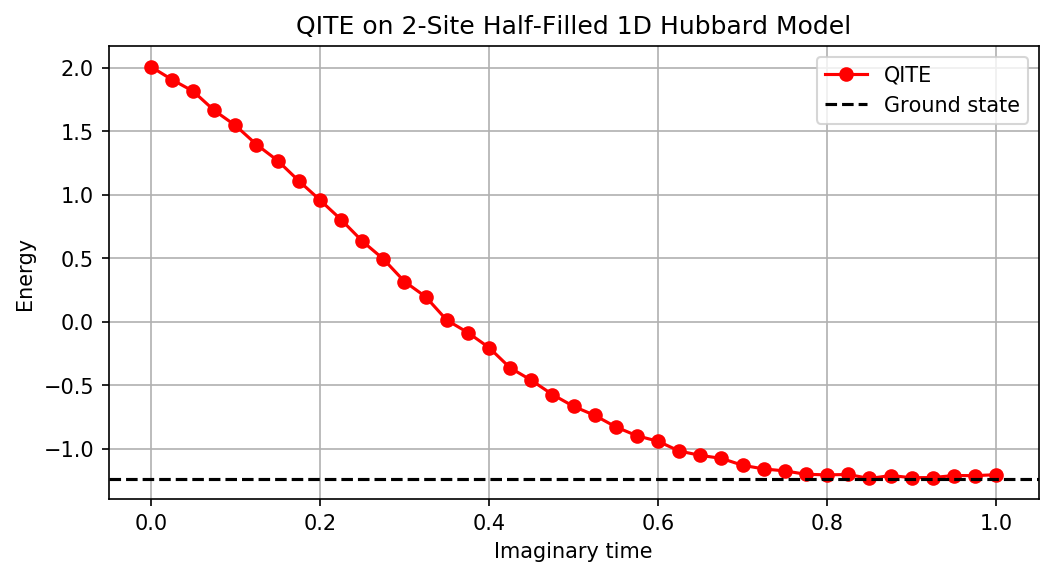

In [14]:
# some trouble with numpy sometimes because of imaginary part... so plot only real part of E
plt.figure(figsize=[8,4], dpi=150)
plt.plot(np.arange(0,N+1)*db,E.real,'-ro',label='QITE')
plt.axhline(y=-1.23607, color='k',linestyle='--',label="Ground state")
plt.title("QITE on 2-Site Half-Filled 1D Hubbard Model")
plt.xlabel("Imaginary time")
plt.ylabel("Energy")
plt.grid()
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.show()

# Classical Simulation

In [15]:
t_hubbard = 1
U_hubbard = 2
beta = N * db
sigma = np.zeros([2, 2, 4], dtype=complex)
sigma[0, 0, 0] = 1.
sigma[1, 1, 0] = 1.
sigma[0, 1, 1] = 1.
sigma[1, 0, 1] = 1.
sigma[0, 1, 2] = -1j
sigma[1, 0, 2] = 1j
sigma[0, 0, 3] = 1.
sigma[1, 1, 3] = -1.
# N = 10 # Number of imaginary time steps

# Defining the Hamiltonian
Hamiltonian = -t_hubbard * (np.kron(sigma[:, :, 1], sigma[:, :, 0]) + np.kron(sigma[:, :, 0], sigma[:, :, 1])) \
             + U_hubbard / 2 * (np.kron(sigma[: ,:, 0], sigma[: ,:, 0]) + np.kron(sigma[:, :, 3], sigma[:, :, 3]))
w, v = np.linalg.eigh(Hamiltonian)
print('The exact solution is ', w[0])

The exact solution is  -1.2360679774997898


In [16]:
# Classical trajectory

# List to store energy values
energy_classical_list = []
energy_qite_list = []

# Initialize into |00> state
psi = np.array([1,0,0,0],dtype=complex)
psi = psi/np.linalg.norm(psi)

db = beta/N
expmH = expm(-db * Hamiltonian)
phi = psi

# Store the energy for initial wavefunction
e = np.matmul(Hamiltonian, phi)
e = np.real(np.matmul(np.transpose(np.conj(phi)), e))
energy_classical_list.append(e)

# Perform imaginary time evolution
for i in range(0,N):

    # Perform imaginary time evolution
    phi = np.matmul(expmH, phi)

    # Require normalization because imaginary time evolution is non-unitary
    phi = phi / np.linalg.norm(phi)

    # Store the energy values at each step
    e = np.matmul(Hamiltonian, phi)
    e = np.real(np.matmul(np.transpose(np.conj(phi)), e))
    energy_classical_list.append(e)
print('Final energy at beta', beta, 'is ', e)

Final energy at beta 1.0 is  -1.216556112674822


# Classical QITE Approximation

In [17]:
# QITE trajectory

phi = psi
print(phi)
# Store the energy for initial wavefunction
e = np.matmul(Hamiltonian, phi)
e = np.real(np.matmul(np.transpose(np.conj(phi)), e))
energy_qite_list.append(e)

debug_Pmu_expectation_list = []

print('We start QITE now')
for i in range(0,N):

    # First construct Pmu_expectation matrices
    Pmu_expectation = np.zeros([16], dtype=complex)
    for Pmu in range(2**4):
        ops = Int2Bas(Pmu, 4, 2)
#         print("ops: ", ops)
        operator = np.kron(sigma[:, :, ops[0]], sigma[:, :, ops[1]])
        Pmu_expectation[Pmu] = np.matmul(np.transpose(np.conj(phi)), np.matmul(operator, phi))
        
    debug_Pmu_expectation_list.append(Pmu_expectation.real.tolist())

    # Now construct S matrix
    S = np.zeros([16, 16], dtype=complex)
    for i in range(16):
        for j in range(16):
            S[i,j] = Pmu_expectation[index[i, j]]*coeff[i, j]

    # Now construct b vector
    b = np.zeros([16], dtype=complex)
    c = 1

    # We will hardcode in the QITE step

    c -= 2 * db * (-t_hubbard) * Pmu_expectation[1]
    c -= 2 * db * (-t_hubbard) * Pmu_expectation[4]
    c -= 2 * db * (U_hubbard / 2) * Pmu_expectation[0]
    c -= 2 * db * (U_hubbard / 2) * Pmu_expectation[15]
    c = np.sqrt(c)
    
    for i in range(16):
        b[i] += (Pmu_expectation[i] / c - Pmu_expectation[i]) / db
        b[i] -= (-t_hubbard) * coeff[i, 1] * Pmu_expectation[index[i, 1]] / c
        b[i] -= (-t_hubbard) * coeff[i, 4] * Pmu_expectation[index[i, 4]] / c
        b[i] -= (U_hubbard / 2) * coeff[i, 0] * Pmu_expectation[index[i, 0]] / c
        b[i] -= (U_hubbard / 2) * coeff[i, 15] * Pmu_expectation[index[i, 15]] / c
        b[i] = 1j * b[i] - 1j * np.conj(b[i])

    # Obtain x 
    dalpha = np.eye(16) * 0.01
    x = np.linalg.lstsq(S + np.transpose(S) + dalpha, -b, rcond=-1)[0]

    # Classical evolution
    U = np.eye(4)
    for i in range(len(x)):
        ops = Int2Bas(i, 4, 2)
        operator = np.kron(sigma[:, :, ops[0]], sigma[:, :, ops[1]])
        U = np.matmul(expm(1j * db * x[i] * operator), U)
    phi = np.matmul(U, phi)
    
    e = np.matmul(Hamiltonian, phi)
    e = np.real(np.matmul(np.transpose(np.conj(phi)), e))
    energy_qite_list.append(e)
print('Final energy from QITE is ', e)

# print(debug_Pmu_expectation_list)

[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
We start QITE now
Final energy from QITE is  -1.2174753385507546


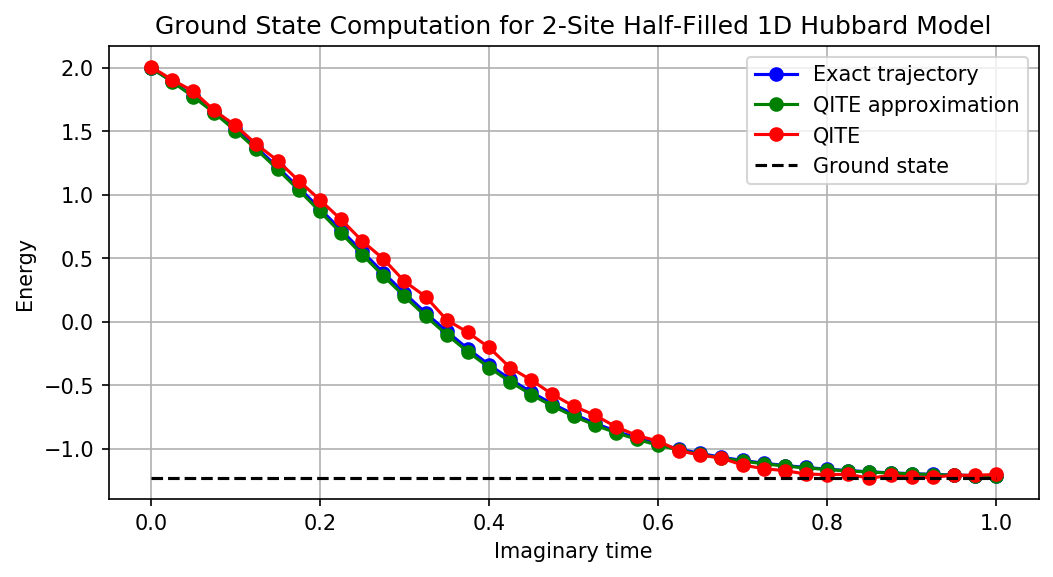

In [18]:
plt.figure(figsize=[8,4], dpi=150)
beta_list = np.asarray(range(0, N+1)) * db
plt.plot(beta_list, energy_classical_list, '-bo', label='Exact trajectory')
plt.plot(beta_list, energy_qite_list, '-go', label='QITE approximation')
plt.plot(np.arange(0,N+1)*db,E.real,'-ro',label='QITE')
plt.plot([beta_list[0], beta_list[-1]], [w[0], w[0]], '--k', label='Ground state')
# plt.axhline(y=w[0], color='k',linestyle='--',label="Ground state")

plt.title("Ground State Computation for 2-Site Half-Filled 1D Hubbard Model")
plt.xlabel("Imaginary time")
plt.ylabel("Energy")
plt.grid()
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.show()